In [5]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

from tqdm.notebook import tqdm

import pickle

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [6]:
_individuals = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
individuals = _individuals.copy()
house_ids = individuals.columns.difference(["pv_1kw"])

# Fix variables
deltat = timedelta(minutes=15)

# Training = 31 days + 1 day for lagged values
training = timedelta(days=31)

# Where do we forecast?
start = datetime(2019, 5, 30, 6, 0, 0)
full_horizon = timedelta(days=7)

# When do we calibrate
start_calibrate = start - timedelta(days=2)
end_calibrate = start - deltat
start_training_to_calibrate = start_calibrate - training
end_training_to_calibrate = start_calibrate - deltat

# To truncate data
end = start + full_horizon + timedelta(days=7)  # keep a few days after anyway

pv_size = 3
individuals = individuals.loc[start_training_to_calibrate-timedelta(days=1):end, :].copy()
for col in individuals.columns:
    individuals[col] -= pv_size * individuals["pv_1kw"]
individuals.drop(columns=["pv_1kw"], inplace=True)

# Forecasting model

In [7]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm

class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors=None,
                 daily_seasonality="auto",
                 seasonality_prior_scale=10.0):

        self._output = output
        self._model = Prophet(
            growth='flat',
            yearly_seasonality=False,
            weekly_seasonality="auto",
            daily_seasonality=daily_seasonality,
            seasonality_mode="additive",
            interval_width=0.95,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=False,
        )
        if regressors is None:
            regressors = list()
        for reg in regressors:
            self._model.add_regressor(
                name=reg["name"],
                prior_scale=reg["prior_scale"])

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


def get_gof(df, result, ref_col, pred_col):
    """
    gof = (1 - NRMSE) * 100
    """
    pred = result.loc[:, [pred_col]].copy()
    #if pred.index.tzinfo is None:
    #    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], [ref_col]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2)
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

def lag_values(df, nb_lag, output_col):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp[output_col].shift(shift)
    return tmp

def predict_n_periods_with_autoreg(df, start_training, end_training, horizon,
                                   deltat, end_complete_pred, freq, output_col,
                                   regressors, nb_lag, seasonality_prior_scale=1.0,
                                   disable_progress_bar=False, daily_seasonality="auto"):
    """
    Train a GAM and predict for horizon T
    Shift prediction start and predict over T again.

    results : [pd.DataFrame] One frame per prediction.
    """

    inputs = [reg["name"] for reg in regressors]
    results = []
    model = GAM(output_col, regressors, daily_seasonality=daily_seasonality,
                seasonality_prior_scale=seasonality_prior_scale)

    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag, output_col)
    model.fit(tmp.loc[start_training:end_training])

    # Number of forecast where we have access to actual data
    forecast_freq = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    for start_prediction in tqdm(forecast_freq, desc="# Forecast: ", disable=disable_progress_bar):
        tmp_results = []
        end_prediction = start_prediction + horizon

        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag, output_col)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))

        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step_i, step in enumerate(horizon_spam):
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.at[step, f"t-{n}"]):
                    tmp.at[step, f"t-{n}"] = tmp_results[step_i-n]

            res = model.predict(tmp.loc[step:step, inputs])
            tmp_results.append(res.at[step, output_col])

        results.append(pd.DataFrame(index=horizon_spam, data={output_col: tmp_results}))
    return results, model

def model_3(graph, start_training, end_training, horizon,
            deltat, end_complete_pred, freq, output_col, scenario):

    regressors = [{"name": "pv_1kw", "prior_scale": scenario["PRIOR_GHI"]}]

    for hour in range(0, 24):
        regressors.append({"name": f"h{hour}", "prior_scale": scenario["PRIOR_HOUR"]})

    nb_lag = list(range(1, scenario["NB_LAG"] + 1))
    for n in nb_lag:
        regressors.append({"name": f"t-{n}", "prior_scale": scenario["PRIOR_LAG"]})

    results, _ = predict_n_periods_with_autoreg(
        graph, start_training, end_training, horizon, deltat, end_complete_pred, freq, output_col,
        regressors,
        nb_lag=nb_lag,
        seasonality_prior_scale=scenario["PRIOR_SEASON"],
        daily_seasonality=scenario["DAILY_FOURIER"],
        disable_progress_bar=True)
    return results

def calibrate(df, individuals, start_training, end_training, horizon, deltat, end_complete_pred, freq, output_col):
    gofs = []
    reference = {
         "NB_LAG": 4,
         "PRIOR_GHI": 3.0,
         "PRIOR_LAG": 10.0,
         "PRIOR_HOUR": 10.0,
         "PRIOR_SEASON": 1.0,
         "DAILY_FOURIER": "auto"}

    scenarios = [reference]
    for i in range(1, 14 + 1):  #  range(1, 24 + 1)
        scenarios.append(dict(reference))
        scenarios[-1]["NB_LAG"] = i

    for i in [1, 5, 8, 10, 15, 20]:
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_GHI"] = i

    for i in [1, 5, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_LAG"] = i

    for i in [8, 15]:  #  [1, 3, 5, 8, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_HOUR"] = i

    for i in [3]:  #  [3, 5, 8, 10, 15, 20]
        scenarios.append(dict(reference))
        scenarios[-1]["PRIOR_SEASON"] = i

    #for i in ["auto", 5, 10, 15, 20, 30]:  # no test
    #    scenarios.append(dict(reference))
    #    scenarios[-1]["DAILY_FOURIER"] = i

    graph = individuals[[output_col]].copy()
    graph["pv_1kw"] = df.loc[graph.index[0]:graph.index[-1], "pv_1kw"]

    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)

    for scenario in tqdm(scenarios, desc="Calibration :"):
        results = model_3(graph, start_training, end_training, horizon,
                    deltat, end_complete_pred, freq, output_col, scenario)

        results = pd.concat(results, axis=0)
        gofs.append(get_gof(individuals, results, output_col, output_col))
        #tmp_gof = []
        #for result in results:
        #    tmp_gof.append(get_gof(individuals, result, output_col, output_col))
        #gofs.append(np.mean(tmp_gof))

    results = pd.DataFrame(data=scenarios)
    results["gof"] = gofs
    return results


# Calibrate & Forecast for each house

In [8]:
default_calibration = {
                 "NB_LAG": 10,
                 "PRIOR_GHI": 10.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"    
}
best_parameters = {name:dict(default_calibration) for name in house_ids}

In [29]:
nb_house = 170

start_training = start - training
end_training = start - deltat

horizon = timedelta(days=2) - deltat
end_complete_pred = start + timedelta(days=7)

freq = "2D"
freq_delta = timedelta(days=2) - deltat

In [9]:
house_netload = {}
#for house_id in tqdm(house_ids[0:nb_house], desc="House #"):

for house_id in tqdm(house_ids[nb_house:nb_house+70], desc="House #"):
    # Add regressor data
    graph = individuals[[house_id]].copy()
    graph["pv_1kw"] = _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]

    graph["_datetime"] = graph.index
    for hour in range(0, 24):
        graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
    graph.drop(columns="_datetime", inplace=True)
    
    # Run model 3
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        results = model_3(graph, start_training, end_training, horizon,
                    deltat, end_complete_pred, freq, house_id, best_parameters[house_id])
    
    house_netload[house_id] = []
    for i in range(0, len(results)):
        _start = results[i].index[0]
        house_netload[house_id].append(results[i].loc[_start:_start + freq_delta, :].copy())
    house_netload[house_id] = pd.concat(house_netload[house_id], axis=0)
        
with open(f'tmp_forecasts/70_houses_forecast_2D.pickle', 'wb') as handle:
    pickle.dump(house_netload, handle, protocol=pickle.HIGHEST_PROTOCOL)

House #: 100%|██████████| 70/70 [1:22:27<00:00, 70.68s/it]


# Randomly pack households in communities

In [15]:
with open(f'tmp_forecasts/70_houses_forecast_2D.pickle', 'rb') as handle:
    house70 = pickle.load(handle)

In [16]:
with open(f'tmp_forecasts/100_houses_forecast_2D.pickle', 'rb') as handle:
    house100 = pickle.load(handle)

In [18]:
house_netload = dict(house100, **house70)

In [36]:
import random

community_netload = {}
community_sizes = np.linspace(2, 120, 119, dtype=int)

for size in community_sizes:
    random_ids = random.sample(list(house_ids[0:nb_house]), k=size)
    concats = [house_netload[i] for i in random_ids]
    community_netload[size] = pd.concat(concats, axis=1)

In [37]:
def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

In [38]:
_start = end_training + deltat
_end = end_complete_pred

cost_pvonly = []

for community_size in community_sizes:
    sub_house_ids = list(community_netload[community_size].columns)
    graph = individuals.loc[_start:_end, sub_house_ids].copy()

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    cost_pvonly.append(forecast_cost / community_size)

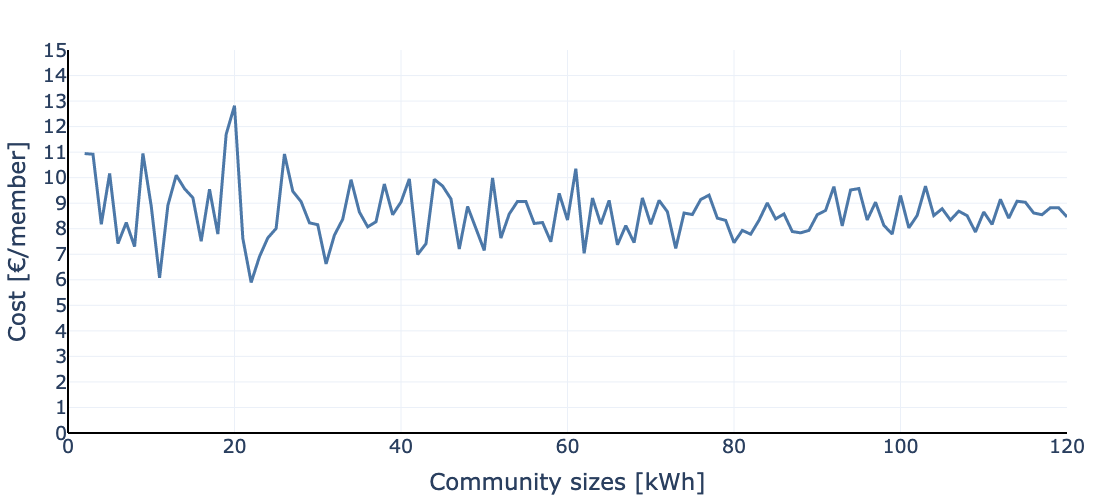

In [40]:
graph = pd.DataFrame(index=community_sizes, 
                     data={"PV_only": cost_pvonly})
#graph = graph[graph["PV_only"] < 13]
fig = px.line(graph)

fig.update_traces(line_width=3)
fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Cost [€/member]",
    xaxis_title="Community sizes [kWh]",
    yaxis_range=[0, 15],
    xaxis_range=[0, 120],
    yaxis_dtick=1,
    yaxis_showline=False, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    showlegend=False)
fig.show()

# Scheduling

In [42]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries_quadratic:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "gurobi"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )
        
        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function_bis(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((1/netloads[i][p] * (m.batteryin[i, b] + m.batteryout[i, b]))**2 for b, p in zip(m.batteries, m.members))
                for i in m.horizon
            )
     
        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((m.batteryin[i, b] + m.batteryout[i, b])**2 for b in m.batteries)
                for i in m.horizon
            )
        m.objective = Objective(rule=objective_function_bis, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [43]:
schedules_concat = {}
energy_concat = {}

community_sizes = list(community_netload.keys())

freq = "2D"
freq_delta = timedelta(days=2) - deltat
aging_cost = 1e-6
battery_size = 5

for community_size in tqdm(community_sizes, desc="Community size"):
    schedules_concat[community_size] = []
    energy_concat[community_size] = []   
    sub_house_ids = list(community_netload[community_size].columns)
    
    ref_spec = {
            "min_kw": battery_size / 2,
            "max_kw": battery_size / 2,
            "max_kwh": battery_size,
            "init_kwh": battery_size * 0.01,
            "eta": 0.95,
            "offset": 0.01}
    spec = [dict(ref_spec) for i in sub_house_ids]
    
    
    model = OptimizeBatteries_quadratic(
        grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=aging_cost,
        verbose=False, only_return_schedules=False)
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in enumerate(date_range):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = community_netload[community_size].loc[opti_start:end_optimization, :]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        schedules_concat[community_size].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
        energy_concat[community_size].append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_delta].copy())
    schedules_concat[community_size] = pd.concat(schedules_concat[community_size], axis=0)
    energy_concat[community_size] = pd.concat(energy_concat[community_size], axis=0)

Community size: 100%|██████████| 119/119 [55:12<00:00, 27.84s/it]


### Perfect optimization

In [44]:
perfect_schedules_concat = {}
perfect_energy_concat = {}

for community_size in tqdm(community_sizes, desc="Community size"):
    perfect_schedules_concat[community_size] = []
    perfect_energy_concat[community_size] = []
    sub_house_ids = list(community_netload[community_size].columns)
    
    ref_spec = {
            "min_kw": battery_size / 2,
            "max_kw": battery_size / 2,
            "max_kwh": battery_size,
            "init_kwh": battery_size * 0.01,
            "eta": 0.95,
            "offset": 0.01}
    spec = [dict(ref_spec) for i in sub_house_ids]
    
    
    model = OptimizeBatteries_quadratic(
        grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
        verbose=False, only_return_schedules=False)
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in enumerate(date_range):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = individuals.loc[opti_start:end_optimization, sub_house_ids]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        perfect_schedules_concat[community_size].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
        perfect_energy_concat[community_size].append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_delta].copy())
    perfect_schedules_concat[community_size] = pd.concat(perfect_schedules_concat[community_size], axis=0)
    perfect_energy_concat[community_size] = pd.concat(perfect_energy_concat[community_size], axis=0)

Community size: 100%|██████████| 119/119 [50:26<00:00, 25.43s/it]


## Compare in €

In [45]:
_start = end_training + deltat
_end = end_complete_pred

In [46]:
cost_2d = []

for community_size in community_sizes:
    sub_house_ids = list(community_netload[community_size].columns)
    graph = schedules_concat[community_size].copy()
    graph.columns = sub_house_ids
    for col in graph.columns:
        graph[col] += individuals.loc[_start:_end, col]

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    #print(f"Forecast for {community_size} houses, cost = {np.round(forecast_cost / community_size, 2)} €/household")
    cost_2d.append(forecast_cost / community_size)

In [47]:
cost_perfect = []

for community_size in community_sizes:
    sub_house_ids = list(community_netload[community_size].columns)
    graph = perfect_schedules_concat[community_size].copy()
    graph.columns = sub_house_ids
    for col in graph.columns:
        graph[col] += individuals.loc[_start:_end, col]

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    #print(f"Forecast for {community_size} houses, cost = {np.round(forecast_cost / community_size, 2)} €/household")
    cost_perfect.append(forecast_cost / community_size)

In [48]:
cost_pvonly = []

for community_size in community_sizes:
    #print(f"Size = {community_size}")
    sub_house_ids = list(community_netload[community_size].columns)
    graph = individuals.loc[_start:_end, sub_house_ids].copy()

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    #print(f"PV only cost = {np.round(forecast_cost / community_size, 2)} €/household")
    cost_pvonly.append(forecast_cost / community_size)

    forecast_cost = community_bill(graph, sub_house_ids, timing="1D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    #print(f"Theoretical 1d cost = {np.round(forecast_cost / community_size, 2)} €/household")

    forecast_cost = community_bill(graph, sub_house_ids, timing="2D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    #print(f"Theoretical 2d cost = {np.round(forecast_cost / community_size, 2)} €/household")

    forecast_cost = community_bill(graph, sub_house_ids, timing="365D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    #print(f"Theoretical cost = {np.round(forecast_cost / community_size, 2)} €/household")
    #print("")

In [1]:
graph = pd.DataFrame(index=community_sizes, data={"2D": cost_2d,
                                                  "Perfect": cost_perfect,
                                                  "PV_only": cost_pvonly})
graph = graph[graph["PV_only"] < 13]

fig = px.line(graph)

fig.update_traces(line_width=3)
fig.update_layout(
    layout,
    height=500,
    width=800,
    yaxis_title="Cost [€]",
    xaxis_title="Community sizes [kWh]",
    yaxis_range=[0, 13.2],
    xaxis_range=[0, 120],
    yaxis_dtick=1,
    yaxis_showline=False, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    showlegend=False)
fig.show()
fig.write_image(f"results/cost_community_size.svg")

NameError: name 'pd' is not defined

In [55]:
with open(f'results/_graph_community_size.pickle', 'wb') as handle:
    pickle.dump(graph, handle, protocol=pickle.HIGHEST_PROTOCOL)

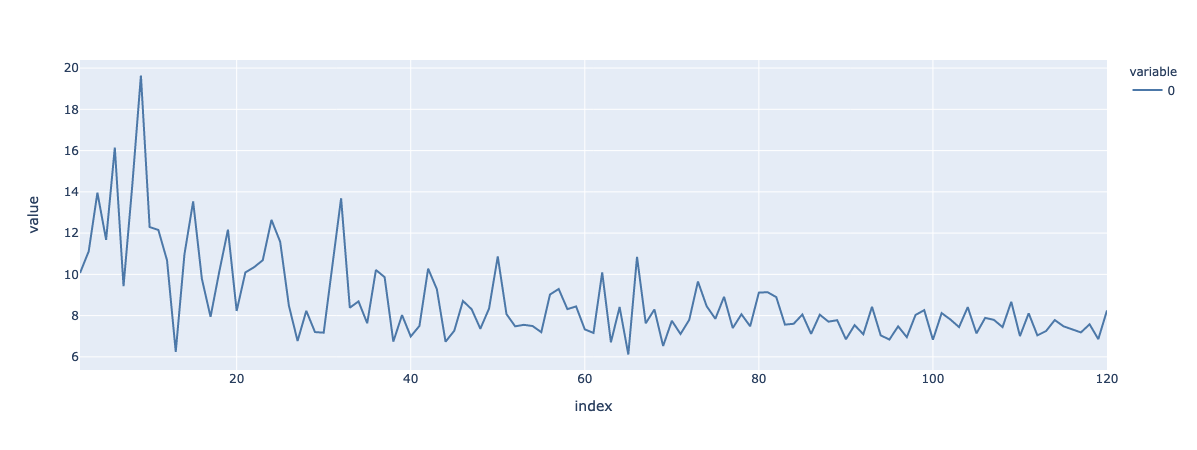

In [54]:
fig = px.line((graph["2D"] - graph["Perfect"]) * 100 / (graph["PV_only"] - graph["Perfect"]))
fig.show()